In [1]:
%matplotlib widget

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


In [173]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import empymod 
from scipy.constants import mu_0
from scipy.constants import epsilon_0
import pygimli as pg

In [3]:
Values = {'Params': ['theta_r', 'theta_s', 'alpha', 'n', 'a', 'b', 'sigma_s', 'sigma_w'],
          'Coarse': [0.025, 0.403, 0.0383, 1.3774, 1.85, 0.0385, 5.89e-4, 0.075],
          'Medium': [0.010, 0.439, 0.0314, 1.1804, 2.10, 0.2450, 8.99e-4, 0.075],
          'Fine'  : [0.010, 0.520, 0.0367, 1.1012, 1.35, -0.090, 4.39e-2, 0.075],
          'Lambot': [0, 0.33, 6.63, 2.57, 1.85, 3.85e-2, 5.89e-4, 0.075]
         }

Models = pd.DataFrame(Values)

Models

,Params,Coarse,Medium,Fine,Lambot
0,theta_r,0.025000,0.010000,0.0100,0.000000
1,theta_s,0.403000,0.439000,0.5200,0.330000
2,alpha,0.038300,0.031400,0.0367,6.630000
3,n,1.377400,1.180400,1.1012,2.570000
4,a,1.850000,2.100000,1.3500,1.850000
5,b,0.038500,0.245000,-0.0900,0.038500
6,sigma_s,0.000589,0.000899,0.0439,0.000589
7,sigma_w,0.075000,0.075000,0.0750,0.075000


In [4]:
# Functions
z =np.linspace(0,2,50, endpoint=False)

def soil_moisture(theta_r, theta_s, z_w, alpha, n, z =z):
    """ Function to define the soil moisture:
    Input:
        theta_r : residual water content [m^3 m ^{-3}]
        theta_s : saturated water content [m^3 m ^{-3}]
        h : pressure head [m]
        alpha : parameter inverse to air entry value [m^{-1}]
        n : parameter inverse of width of pore size distribution
        z_w : water table location (positive pointing down)
        
    Output:
        theta : water retention [m^3 m ^{-3}]
        
    """
    h = z - z_w
    m = 1 - 1/n
    
    theta = []
    
    for hi in h:
        if hi < 0:
            theta.append(theta_r + (theta_s - theta_r) * (1 + np.abs(alpha * hi)**n)**(-m))
        else:
            theta.append(theta_s)
        
    return np.array(theta)
    

def elec_cond_soil_moist(theta, sigma_w, sigma_s, a, b):
    """ Function to calculate electrical conductivity with respect to soil moisture
    Input:
        theta : soil moisture [m^3 m ^{-3}]
        sigma_w : electrical conductivity of soil solution [S/m]
        sigma_r : electrical conductivity of dry soil [S/m]
        a, b : soil parameters
        
    Output:
        sigma : electrical conductivity [S/m]
        
    """
    
    sigma = (a * theta**2 + b * theta) * sigma_w + sigma_s
    
    return sigma

In [5]:
theta_coarse = soil_moisture(theta_r = Models['Coarse'][0], 
                             theta_s = Models['Coarse'][1],
                             z_w = 1,                      # Assumption
                             alpha = Models['Coarse'][2],
                             n = Models['Coarse'][3])

sigma_coarse = elec_cond_soil_moist(theta_coarse, 
                                    sigma_w = Models['Coarse'][7],
                                    sigma_s = Models['Coarse'][6],
                                    a = Models['Coarse'][4],
                                    b = Models['Coarse'][5])

theta_medium = soil_moisture(theta_r = Models['Medium'][0], 
                             theta_s = Models['Medium'][1],
                             z_w = 1,                      # Assumption
                             alpha = Models['Medium'][2],
                             n = Models['Medium'][3])

sigma_medium = elec_cond_soil_moist(theta_medium, 
                                    sigma_w = Models['Medium'][7],
                                    sigma_s = Models['Medium'][6],
                                    a = Models['Medium'][4],
                                    b = Models['Medium'][5])

theta_fine = soil_moisture(theta_r = Models['Fine'][0], 
                           theta_s = Models['Fine'][1],
                           z_w = 1,                      # Assumption
                           alpha = Models['Fine'][2],
                           n = Models['Fine'][3])

sigma_fine = elec_cond_soil_moist(theta_fine, 
                                  sigma_w = Models['Fine'][7],
                                  sigma_s = Models['Fine'][6],
                                  a = Models['Fine'][4],
                                  b = Models['Fine'][5])

theta_lambot = soil_moisture(theta_r = Models['Lambot'][0], 
                             theta_s = Models['Lambot'][1],
                             z_w = 1,                      # Assumption
                             alpha = Models['Lambot'][2],
                             n = Models['Lambot'][3])

sigma_lambot = elec_cond_soil_moist(theta_lambot, 
                                    sigma_w = Models['Lambot'][7],
                                    sigma_s = Models['Lambot'][6],
                                    a = Models['Lambot'][4],
                                    b = Models['Lambot'][5])

Text(0.5, 0, '$\\sigma$ [mS/m]')

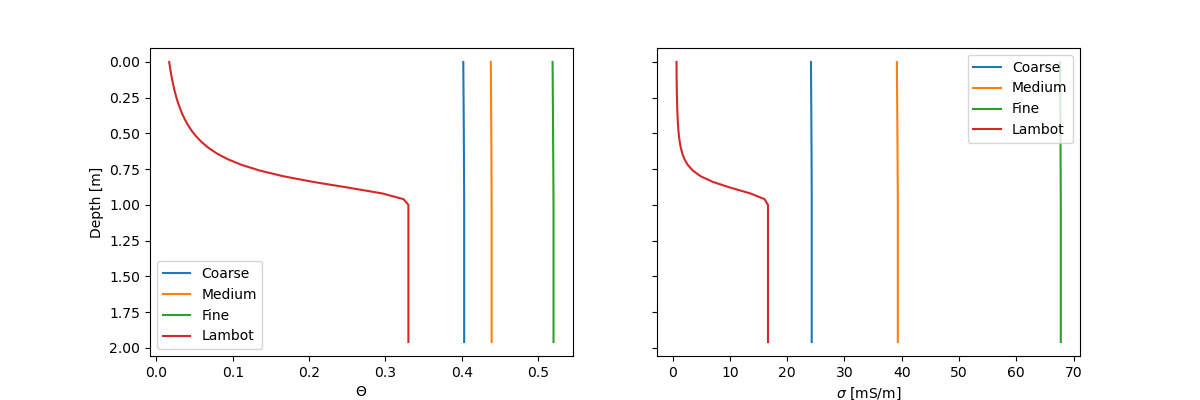

In [6]:
fig, ax = plt.subplots(1,2, sharey=True, figsize=(12,4))

ax[0].plot(theta_coarse, z, label='Coarse')
ax[1].plot(sigma_coarse*1000, z, label='Coarse')
ax[0].plot(theta_medium, z, label='Medium')
ax[1].plot(sigma_medium*1000, z, label='Medium')
ax[0].plot(theta_fine, z, label='Fine')
ax[1].plot(sigma_fine*1000, z, label='Fine')
ax[0].plot(theta_lambot, z, label='Lambot')
ax[1].plot(sigma_lambot*1000, z, label='Lambot')
ax[0].invert_yaxis()
ax[0].legend()
ax[1].legend()
ax[0].set_xlabel('$\Theta$')
ax[0].set_ylabel('Depth [m]')
ax[1].set_xlabel('$\sigma$ [mS/m]')

In [7]:
# Let's calculate data for each

def DualEM_842s(depth, res, coil_orient=np.array(['H', 'P', 'V']), height=0.15):
    """ Here we compute DualEM 842s data using the function `empymod.dipole` function
    for a 1D earth resistivity model
    
    We model the impedance ratio (Z) between the primary (H_p) and secondary (H_s) magnetic fields
    
    The data computed is returned in Quadrature or Out-of-Phase (OP) and In-Phase (IP) components 
    for each coil orientation and coil-coil separation:
    
    H : Horizontal Coplanar -> 2 m, 4 m 8 m coil-coil separation
    V : Vertical Coplanar   -> 2 m, 4 m 8 m coil-coil separation
    P : Perpendicular       -> 2.1 m, 4.1 m 8.1 m coil-coil separation
    Using a Frequency of 9000 Hz
    
    Parameters
    ----------
    depth : ndarray
        Depths of the resistivity model
        
    res : ndarray
        Resistivities of the resistivity model
        
    coil_orient : array of str, e.g.: np.array(['H', 'V', 'P'])
        coil orientations: 'H' for horizontal coplanar, 'V' for vertical coplanar, 'P' for perpendicular
    
    height : float
        height of the device with respect to ground surface [m]
    
    Returns
    -------
    DualEM : ndarray
        DualEM response [OP, IP] for each coil orientation and each coil offset [ppt]
        in parts per thousand
        
        shape: [nr of coil orientations, 2, nr of coil offsets]  
    """
    
    if len(depth) != len(res):
        raise TypeError('depth and res arrays should have the same length!')
    
    # Define DualEM 842s parameters
    
    Freq = 9000
    coil_spacing = [2, 4, 8]
    coil_spacing_p = [2.1, 4.1, 8.2]
    
    res_air = 1e6 # air resistivity
    
    # Define source and receivers geometry
    
    source = [0, 0, -height]
    receivers = [coil_spacing, np.zeros_like(coil_spacing), -height]
    receivers_p = [coil_spacing_p, np.zeros_like(coil_spacing_p), -height]
    
    # Define resistivity model
    res = np.hstack((res_air, res)) # include air resistivity
    
    # Empty array to store store responses
    OUT = []
    
    # Calculate for horizontal coil orientation
    if any(coil_orient == 'H'):
        # Secondary magnetic field
        H_Hs = empymod.dipole(source, receivers, depth, res, Freq, ab = 66, xdirect = None, 
                              verb=0)*(2j * np.pi * Freq * mu_0) 
        # Primary magnetic field
        H_Hp = empymod.dipole(source, receivers, depth=[], res=[res_air], freqtime = Freq,
                              ab = 66, verb=0)*(2j * np.pi * Freq * mu_0)   
        op = (H_Hs/H_Hp).imag.amp() * 1e3 # Out of Phase
        ip = (H_Hs/H_Hp).real.amp() * 1e3 # In Phase
        OUT.append([op, ip])

    # Calculate for vertical coil orientation
    if any(coil_orient == 'V'):
        # Secondary magnetic field
        V_Hs = empymod.dipole(source, receivers, depth, res, Freq, ab = 55, xdirect = None, 
                              verb=0)*(2j * np.pi * Freq * mu_0) 
        # Primary magnetic field
        V_Hp = empymod.dipole(source, receivers, depth=[], res=[res_air], freqtime = Freq, ab = 55, 
                              verb=0)*(2j * np.pi * Freq * mu_0)
        op = (V_Hs/V_Hp).imag.amp() * 1e3 # Out of Phase
        ip = (V_Hs/V_Hp).real.amp() * 1e3 # In Phase
        OUT.append([op, ip])

    # Calculate for perpendicular coil orientation
    if any(coil_orient == 'P'):
        P_Hs = empymod.dipole(source, receivers, depth, res, Freq, ab = 46, xdirect = None, 
                              verb=0)*(2j * np.pi * Freq * mu_0) 
        P_Hp = empymod.dipole(source, receivers, depth=[], res=[res_air], freqtime= Freq,
                              ab = 66, verb = 0)*(2j * np.pi * Freq * mu_0) 
        op = (P_Hs/P_Hp).imag.amp() * 1e3 # Out of Phase
        ip = (P_Hs/P_Hp).real.amp() * 1e3 # In Phase

        OUT.append([op, ip])

    return np.array(OUT).ravel() # [HOP, HIP, VOP, VIP, POP, PIP]

def fop(alpha, n , z_w, theta_r, theta_s, a, b, sigma_w, sigma_s, z):
    
    """ forward operator that transforms soil parameters into
    FDEM measurements """
    
    soil_moist = soil_moisture(theta_r, theta_s, z_w, alpha, n, z)
    sigma = elec_cond_soil_moist(soil_moist, sigma_w, sigma_s, a, b)
    data = DualEM_842s(depth=z, res=1/sigma)
    
    return data    

In [8]:
data_coarse = fop(alpha = Models['Coarse'][2],
                  n     = Models['Coarse'][3],
                  z_w   = 1,
                  theta_r = Models['Coarse'][0],
                  theta_s = Models['Coarse'][1],
                  a       = Models['Coarse'][4],
                  b       = Models['Coarse'][5],
                  sigma_w = Models['Coarse'][7],
                  sigma_s = Models['Coarse'][6],
                  z = z)

data_medium = fop(alpha = Models['Medium'][2],
                  n     = Models['Medium'][3],
                  z_w   = 1,
                  theta_r = Models['Medium'][0],
                  theta_s = Models['Medium'][1],
                  a       = Models['Medium'][4],
                  b       = Models['Medium'][5],
                  sigma_w = Models['Medium'][7],
                  sigma_s = Models['Medium'][6],
                  z = z)

data_fine = fop(alpha = Models['Fine'][2],
                  n     = Models['Fine'][3],
                  z_w   = 1,
                  theta_r = Models['Fine'][0],
                  theta_s = Models['Fine'][1],
                  a       = Models['Fine'][4],
                  b       = Models['Fine'][5],
                  sigma_w = Models['Fine'][7],
                  sigma_s = Models['Fine'][6],
                  z = z)

data_lambot = fop(alpha = Models['Lambot'][2],
                  n     = Models['Lambot'][3],
                  z_w   = 1,
                  theta_r = Models['Lambot'][0],
                  theta_s = Models['Lambot'][1],
                  a       = Models['Lambot'][4],
                  b       = Models['Lambot'][5],
                  sigma_w = Models['Lambot'][7],
                  sigma_s = Models['Lambot'][6],
                  z = z)

Text(0, 0.5, 'PPT')

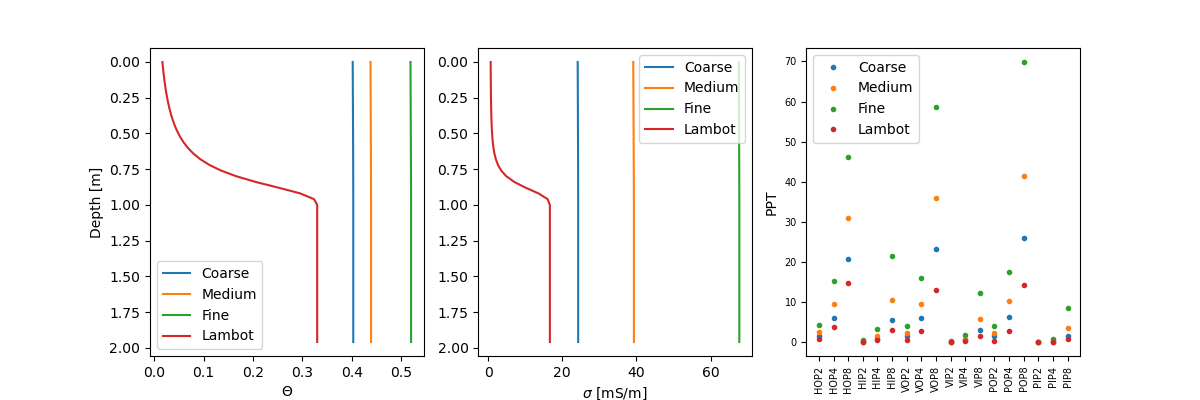

In [9]:
fig, ax = plt.subplots(1,3, figsize=(12,4))

ax[0].plot(theta_coarse, z, label='Coarse')
ax[1].plot(sigma_coarse*1000, z, label='Coarse')
ax[0].plot(theta_medium, z, label='Medium')
ax[1].plot(sigma_medium*1000, z, label='Medium')
ax[0].plot(theta_fine, z, label='Fine')
ax[1].plot(sigma_fine*1000, z, label='Fine')
ax[0].plot(theta_lambot, z, label='Lambot')
ax[1].plot(sigma_lambot*1000, z, label='Lambot')

ax[2].plot(data_coarse, '.', label='Coarse')
ax[2].plot(data_medium, '.', label='Medium')
ax[2].plot(data_fine, '.', label='Fine')
ax[2].plot(data_lambot, '.', label='Lambot')
ax[2].legend()

ax[0].invert_yaxis()
ax[1].invert_yaxis()
ax[0].legend()
ax[1].legend()
ax[0].set_xlabel('$\Theta$')
ax[0].set_ylabel('Depth [m]')
ax[1].set_xlabel('$\sigma$ [mS/m]')


data_lab = ['HOP2','HOP4', 'HOP8', 'HIP2', 'HIP4', 'HIP8', 
               'VOP2','VOP4', 'VOP8', 'VIP2', 'VIP4', 'VIP8',
               'POP2','POP4', 'POP8', 'PIP2', 'PIP4', 'PIP8']

ax[2].set_xticks(range(0, len(data_lab)))
ax[2].set_xticklabels(data_lab, rotation='vertical')
ax[2].tick_params(labelsize=7)
ax[2].set_ylabel('PPT')

# Data analysis

In [10]:


def FDEM(depth, res, coil_orient=np.array(['H', 'P', 'V']), height=0.15):

    #depth = z.copy()
    #res = 1/sigma_coarse
    #height = 0.15
    #coil_orient=np.array(['H', 'P', 'V'])

    # Define instrument parameters

    Freq = np.logspace(0,6)
    coil_spacing = np.linspace(1,12)
    coil_spacing_p = np.linspace(1,12)

    res_air = 1e6 # air resistivity

    # Define source and receivers geometry

    source = [0, 0, -height]
    receivers = [coil_spacing, np.zeros_like(coil_spacing), -height]
    receivers_p = [coil_spacing_p, np.zeros_like(coil_spacing_p), -height]

    # Define resistivity model
    res = np.hstack((res_air, res)) # include air resistivity

    # Empty array to store store responses
    OUT = []

    # Calculate for horizontal coil orientation
    if any(coil_orient == 'H'):
        # Secondary magnetic field
        H_Hs = empymod.dipole(source, receivers, depth, res, Freq, ab = 66, xdirect = None, 
                              verb=0)*(2j * np.pi * Freq * mu_0) 
        # Primary magnetic field
        H_Hp = empymod.dipole(source, receivers, depth=[], res=[res_air], freqtime = Freq,
                              ab = 66, verb=0)*(2j * np.pi * Freq * mu_0)   
        op = (H_Hs/H_Hp).imag.amp() * 1e3 # Out of Phase
        ip = (H_Hs/H_Hp).real.amp() * 1e3 # In Phase
        OUT.append([op, ip])

    # Calculate for vertical coil orientation
    if any(coil_orient == 'V'):
        # Secondary magnetic field
        V_Hs = empymod.dipole(source, receivers, depth, res, Freq, ab = 55, xdirect = None, 
                              verb=0)*(2j * np.pi * Freq * mu_0) 
        # Primary magnetic field
        V_Hp = empymod.dipole(source, receivers, depth=[], res=[res_air], freqtime = Freq, ab = 55, 
                              verb=0)*(2j * np.pi * Freq * mu_0)
        op = (V_Hs/V_Hp).imag.amp() * 1e3 # Out of Phase
        ip = (V_Hs/V_Hp).real.amp() * 1e3 # In Phase
        OUT.append([op, ip])

    # Calculate for perpendicular coil orientation
    if any(coil_orient == 'P'):
        P_Hs = empymod.dipole(source, receivers, depth, res, Freq, ab = 46, xdirect = None, 
                              verb=0)*(2j * np.pi * Freq * mu_0) 
        P_Hp = empymod.dipole(source, receivers, depth=[], res=[res_air], freqtime= Freq,
                              ab = 66, verb = 0)*(2j * np.pi * Freq * mu_0) 
        op = (P_Hs/P_Hp).imag.amp() * 1e3 # Out of Phase
        ip = (P_Hs/P_Hp).real.amp() * 1e3 # In Phase

        OUT.append([op, ip])

    return np.array(OUT) # [HOP, HIP, VOP, VIP, POP, PIP]

In [11]:
data_coarse = FDEM(z,1/sigma_coarse)
data_medium = FDEM(z,1/sigma_medium)
data_fine = FDEM(z,1/sigma_fine)
data_lambot = FDEM(z,1/sigma_lambot)

In [166]:
# Calculate induction number

Freq_l = np.logspace(0,6)
coil_spacing_l = np.linspace(1,12)

def coilsp_induction_number_1(Freq, sigma_1):
    
    coil_sp = 1 / np.sqrt(sigma_1 * np.pi * Freq * mu_0)
    return coil_sp
    
coil_sp_in_1_coarse = coilsp_induction_number_1(Freq_l, sigma_coarse[0])
coil_sp_in_1_medium = coilsp_induction_number_1(Freq_l, sigma_medium[0])
coil_sp_in_1_fine = coilsp_induction_number_1(Freq_l, sigma_fine[0])
coil_sp_in_1_lambot = coilsp_induction_number_1(Freq_l, sigma_lambot[0])
   

In [181]:
# calculate omega_epsilon (diffusive field condition)

def omega_eps(Freq_l, sigma_1, epsilon_r):
    epsilon = epsilon_r * epsilon_0
    omega_eps = np.abs(2 * np.pi * Freq_l * epsilon)
    diffusive = (omega_eps < sigma_1)
    return diffusive
    
epsilon_r = 5
    
omega_eps(Freq_l, sigma_coarse[0], epsilon_r) 
    

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True])

In [182]:
omega_eps(Freq_l, sigma_medium[0], epsilon_r) 

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True])

In [183]:
omega_eps(Freq_l, sigma_fine[0], epsilon_r) 

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True])

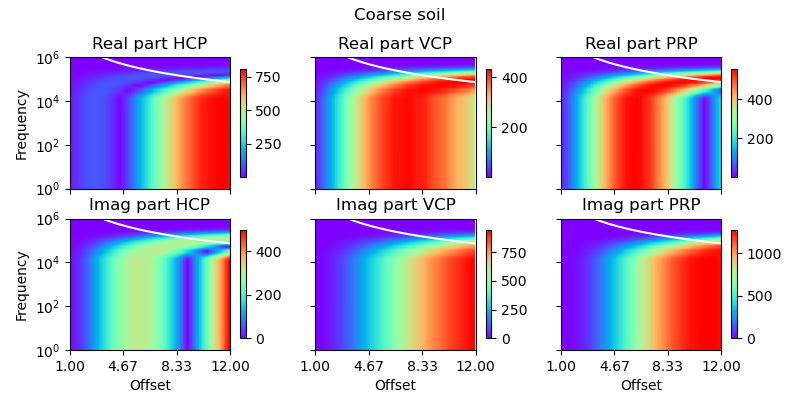

In [133]:
fig, ax = plt.subplots(2,3, figsize=(8,4), sharex=True, sharey=True)
# data (nfreq, nrec, nsrc)

Freq = np.logspace(0,6,6)
coil_spacing = np.linspace(1,12,4)

c = ax[0,0].imshow(data_coarse[0][0], extent=[1, 12, 1, 1e6], aspect=1.5, cmap='rainbow')
ax[0,0].plot(coil_sp_in_1_coarse, Freq_l, 'w')
ax[0,0].set_title('Real part HCP')
fig.colorbar(c, ax=ax[0,0], shrink=0.8)

c = ax[1,0].imshow(data_coarse[0][1], extent=[1, 12, 1, 1e6], aspect=1.5, cmap='rainbow')
ax[1,0].plot(coil_sp_in_1_coarse, Freq_l, 'w')
ax[1,0].set_title('Imag part HCP')
fig.colorbar(c, ax=ax[1,0], shrink=0.8)

c = ax[0,1].imshow(data_coarse[1][0], extent=[1, 12, 1, 1e6], aspect=1.5, cmap='rainbow')
ax[0,1].plot(coil_sp_in_1_coarse, Freq_l, 'w')
ax[0,1].set_title('Real part VCP')
fig.colorbar(c, ax=ax[0,1], shrink=0.8)

c = ax[1,1].imshow(data_coarse[1][1], extent=[1, 12, 1, 1e6], aspect=1.5, cmap='rainbow')
ax[1,1].plot(coil_sp_in_1_coarse, Freq_l, 'w')
ax[1,1].set_title('Imag part VCP')
fig.colorbar(c, ax=ax[1,1], shrink=0.8)

c = ax[0,2].imshow(data_coarse[2][0], extent=[1, 12, 1, 1e6], aspect=1.5, cmap='rainbow')
ax[0,2].plot(coil_sp_in_1_coarse, Freq_l, 'w')
ax[0,2].set_title('Real part PRP')
fig.colorbar(c, ax=ax[0,2], shrink=0.8)

c = ax[1,2].imshow(data_coarse[2][1], extent=[1, 12, 1, 1e6], aspect=1.5, cmap='rainbow')
ax[1,2].plot(coil_sp_in_1_coarse, Freq_l, 'w')
ax[1,2].set_title('Imag part PRP')
fig.colorbar(c, ax=ax[1,2], shrink=0.8)

ax[0,0].set_yticks(Freq,)
ax[0,0].set_yscale('log')
ax[0,0].set_ylim([np.min(Freq), np.max(Freq)])
ax[0,0].set_xlim([np.min(coil_spacing), np.max(coil_spacing)])
ax[0,0].set_xticks(coil_spacing)
ax[1,0].set_xlabel('Offset')
ax[1,1].set_xlabel('Offset')
ax[1,2].set_xlabel('Offset')
ax[0,0].set_ylabel('Frequency')
ax[1,0].set_ylabel('Frequency')

fig.suptitle('Coarse soil')

plt.tight_layout()

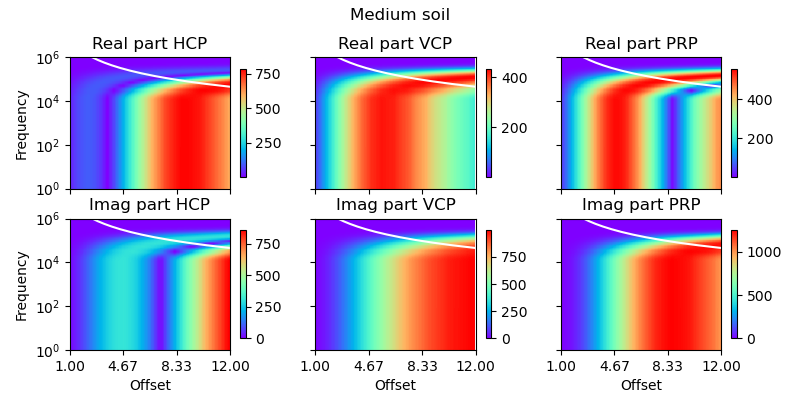

In [134]:
fig, ax = plt.subplots(2,3, figsize=(8,4), sharex=True, sharey=True)
# data (nfreq, nrec, nsrc)

Freq = np.logspace(0,6,6)
coil_spacing = np.linspace(1,12,4)

c = ax[0,0].imshow(data_medium[0][0], extent=[1, 12, 1, 1e6], aspect=1.5, cmap='rainbow')
ax[0,0].plot(coil_sp_in_1_medium, Freq_l, 'w')
ax[0,0].set_title('Real part HCP')
fig.colorbar(c, ax=ax[0,0], shrink=0.8)

c = ax[1,0].imshow(data_medium[0][1], extent=[1, 12, 1, 1e6], aspect=1.5, cmap='rainbow')
ax[1,0].plot(coil_sp_in_1_medium, Freq_l, 'w')
ax[1,0].set_title('Imag part HCP')
fig.colorbar(c, ax=ax[1,0], shrink=0.8)

c = ax[0,1].imshow(data_medium[1][0], extent=[1, 12, 1, 1e6], aspect=1.5, cmap='rainbow')
ax[0,1].plot(coil_sp_in_1_medium, Freq_l, 'w')
ax[0,1].set_title('Real part VCP')
fig.colorbar(c, ax=ax[0,1], shrink=0.8)

c = ax[1,1].imshow(data_medium[1][1], extent=[1, 12, 1, 1e6], aspect=1.5, cmap='rainbow')
ax[1,1].plot(coil_sp_in_1_medium, Freq_l, 'w')
ax[1,1].set_title('Imag part VCP')
fig.colorbar(c, ax=ax[1,1], shrink=0.8)

c = ax[0,2].imshow(data_medium[2][0], extent=[1, 12, 1, 1e6], aspect=1.5, cmap='rainbow')
ax[0,2].plot(coil_sp_in_1_medium, Freq_l, 'w')
ax[0,2].set_title('Real part PRP')
fig.colorbar(c, ax=ax[0,2], shrink=0.8)

c = ax[1,2].imshow(data_medium[2][1], extent=[1, 12, 1, 1e6], aspect=1.5, cmap='rainbow')
ax[1,2].plot(coil_sp_in_1_medium, Freq_l, 'w')
ax[1,2].set_title('Imag part PRP')
fig.colorbar(c, ax=ax[1,2], shrink=0.8)

ax[0,0].set_yticks(Freq,)
ax[0,0].set_yscale('log')
ax[0,0].set_xticks(coil_spacing)
ax[0,0].set_ylim([np.min(Freq), np.max(Freq)])
ax[0,0].set_xlim([np.min(coil_spacing), np.max(coil_spacing)])
ax[1,0].set_xlabel('Offset')
ax[1,1].set_xlabel('Offset')
ax[1,2].set_xlabel('Offset')
ax[0,0].set_ylabel('Frequency')
ax[1,0].set_ylabel('Frequency')

fig.suptitle('Medium soil')

plt.tight_layout()

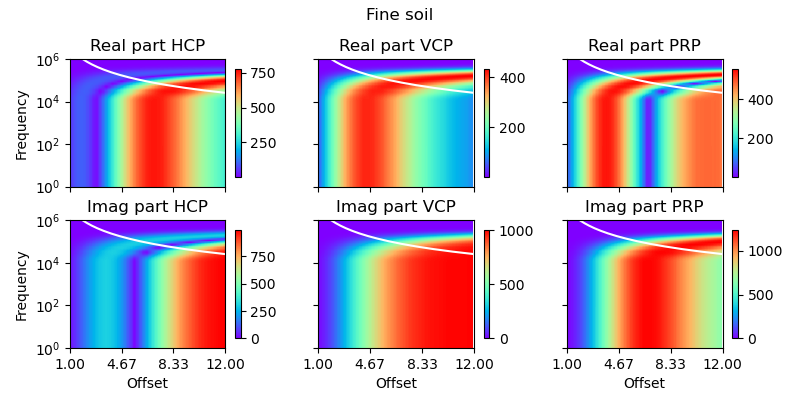

In [135]:
fig, ax = plt.subplots(2,3, figsize=(8,4), sharex=True, sharey=True)
# data (nfreq, nrec, nsrc)

Freq = np.logspace(0,6,6)
coil_spacing = np.linspace(1,12,4)

c = ax[0,0].imshow(data_fine[0][0], extent=[1, 12, 1, 1e6], aspect=1.5, cmap='rainbow')
ax[0,0].plot(coil_sp_in_1_fine, Freq_l, 'w')
ax[0,0].set_title('Real part HCP')
fig.colorbar(c, ax=ax[0,0], shrink=0.8)

c = ax[1,0].imshow(data_fine[0][1], extent=[1, 12, 1, 1e6], aspect=1.5, cmap='rainbow')
ax[1,0].plot(coil_sp_in_1_fine, Freq_l, 'w')
ax[1,0].set_title('Imag part HCP')
fig.colorbar(c, ax=ax[1,0], shrink=0.8)

c = ax[0,1].imshow(data_fine[1][0], extent=[1, 12, 1, 1e6], aspect=1.5, cmap='rainbow')
ax[0,1].plot(coil_sp_in_1_fine, Freq_l, 'w')
ax[0,1].set_title('Real part VCP')
fig.colorbar(c, ax=ax[0,1], shrink=0.8)

c = ax[1,1].imshow(data_fine[1][1], extent=[1, 12, 1, 1e6], aspect=1.5, cmap='rainbow')
ax[1,1].plot(coil_sp_in_1_fine, Freq_l, 'w')
ax[1,1].set_title('Imag part VCP')
fig.colorbar(c, ax=ax[1,1], shrink=0.8)

c = ax[0,2].imshow(data_fine[2][0], extent=[1, 12, 1, 1e6], aspect=1.5, cmap='rainbow')
ax[0,2].plot(coil_sp_in_1_fine, Freq_l, 'w')
ax[0,2].set_title('Real part PRP')
fig.colorbar(c, ax=ax[0,2], shrink=0.8)

c = ax[1,2].imshow(data_fine[2][1], extent=[1, 12, 1, 1e6], aspect=1.5, cmap='rainbow')
ax[1,2].plot(coil_sp_in_1_fine, Freq_l, 'w')
ax[1,2].set_title('Imag part PRP')
fig.colorbar(c, ax=ax[1,2], shrink=0.8)

ax[0,0].set_yticks(Freq,)
ax[0,0].set_yscale('log')
ax[0,0].set_xticks(coil_spacing)
ax[0,0].set_ylim([np.min(Freq), np.max(Freq)])
ax[0,0].set_xlim([np.min(coil_spacing), np.max(coil_spacing)])
ax[1,0].set_xlabel('Offset')
ax[1,1].set_xlabel('Offset')
ax[1,2].set_xlabel('Offset')
ax[0,0].set_ylabel('Frequency')
ax[1,0].set_ylabel('Frequency')

fig.suptitle('Fine soil')

plt.tight_layout()

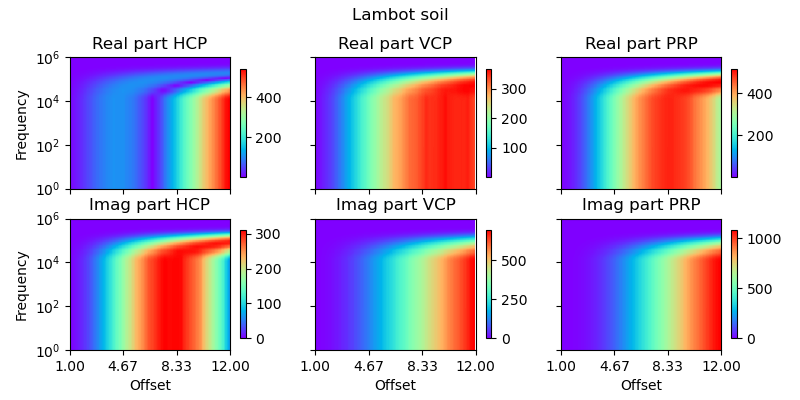

In [136]:
fig, ax = plt.subplots(2,3, figsize=(8,4), sharex=True, sharey=True)
# data (nfreq, nrec, nsrc)

Freq = np.logspace(0,6,6)
coil_spacing = np.linspace(1,12,4)

c = ax[0,0].imshow(data_lambot[0][0], extent=[1, 12, 1, 1e6], aspect=1.5, cmap='rainbow')
ax[0,0].plot(coil_sp_in_1_lambot, Freq_l, 'w')
ax[0,0].set_title('Real part HCP')
fig.colorbar(c, ax=ax[0,0], shrink=0.8)

c = ax[1,0].imshow(data_lambot[0][1], extent=[1, 12, 1, 1e6], aspect=1.5, cmap='rainbow')
ax[1,0].plot(coil_sp_in_1_lambot, Freq_l, 'w')
ax[1,0].set_title('Imag part HCP')
fig.colorbar(c, ax=ax[1,0], shrink=0.8)

c = ax[0,1].imshow(data_lambot[1][0], extent=[1, 12, 1, 1e6], aspect=1.5, cmap='rainbow')
ax[0,1].plot(coil_sp_in_1_lambot, Freq_l, 'w')
ax[0,1].set_title('Real part VCP')
fig.colorbar(c, ax=ax[0,1], shrink=0.8)

c = ax[1,1].imshow(data_lambot[1][1], extent=[1, 12, 1, 1e6], aspect=1.5, cmap='rainbow')
ax[1,1].plot(coil_sp_in_1_lambot, Freq_l, 'w')
ax[1,1].set_title('Imag part VCP')
fig.colorbar(c, ax=ax[1,1], shrink=0.8)

c = ax[0,2].imshow(data_lambot[2][0], extent=[1, 12, 1, 1e6], aspect=1.5, cmap='rainbow')
ax[0,2].plot(coil_sp_in_1_lambot, Freq_l, 'w')
ax[0,2].set_title('Real part PRP')
fig.colorbar(c, ax=ax[0,2], shrink=0.8)

c = ax[1,2].imshow(data_lambot[2][1], extent=[1, 12, 1, 1e6], aspect=1.5, cmap='rainbow')
ax[1,2].plot(coil_sp_in_1_lambot, Freq_l, 'w')
ax[1,2].set_title('Imag part PRP')
fig.colorbar(c, ax=ax[1,2], shrink=0.8)

ax[0,0].set_yticks(Freq,)
ax[0,0].set_yscale('log')
ax[0,0].set_xticks(coil_spacing)
ax[0,0].set_ylim([np.min(Freq), np.max(Freq)])
ax[0,0].set_xlim([np.min(coil_spacing), np.max(coil_spacing)])
ax[1,0].set_xlabel('Offset')
ax[1,1].set_xlabel('Offset')
ax[1,2].set_xlabel('Offset')
ax[0,0].set_ylabel('Frequency')
ax[1,0].set_ylabel('Frequency')

fig.suptitle('Lambot soil')

plt.tight_layout()

# Calculate Frechet derivatives for alpha

In [124]:
# Example change in alpha of 0.01

def fop(alpha, n , z_w, theta_r, theta_s, a, b, sigma_w, sigma_s, z):
    
    """ forward operator that transforms soil parameters into
    FDEM measurements """
    
    soil_moist = soil_moisture(theta_r, theta_s, z_w, alpha, n, z)
    sigma = elec_cond_soil_moist(soil_moist, sigma_w, sigma_s, a, b)
    data = FDEM(depth=z, res=1/sigma)
    
    return data 

delta = 0.01

data_coarse_1 = fop(alpha = Models['Coarse'][2],
                  n     = Models['Coarse'][3],
                  z_w   = 1,
                  theta_r = Models['Coarse'][0],
                  theta_s = Models['Coarse'][1],
                  a       = Models['Coarse'][4],
                  b       = Models['Coarse'][5],
                  sigma_w = Models['Coarse'][7],
                  sigma_s = Models['Coarse'][6],
                  z = z)

data_coarse_2 = fop(alpha = Models['Coarse'][2]+delta,
                  n     = Models['Coarse'][3],
                  z_w   = 1,
                  theta_r = Models['Coarse'][0],
                  theta_s = Models['Coarse'][1],
                  a       = Models['Coarse'][4],
                  b       = Models['Coarse'][5],
                  sigma_w = Models['Coarse'][7],
                  sigma_s = Models['Coarse'][6],
                  z = z)

FreDev_coarse = (data_coarse_1 - data_coarse_2)/data_coarse_1



In [125]:
data_medium_1 = fop(alpha = Models['Medium'][2],
                  n     = Models['Medium'][3],
                  z_w   = 1,
                  theta_r = Models['Medium'][0],
                  theta_s = Models['Medium'][1],
                  a       = Models['Medium'][4],
                  b       = Models['Medium'][5],
                  sigma_w = Models['Medium'][7],
                  sigma_s = Models['Medium'][6],
                  z = z)

data_medium_2 = fop(alpha = Models['Medium'][2]+delta,
                  n     = Models['Medium'][3],
                  z_w   = 1,
                  theta_r = Models['Medium'][0],
                  theta_s = Models['Medium'][1],
                  a       = Models['Medium'][4],
                  b       = Models['Medium'][5],
                  sigma_w = Models['Medium'][7],
                  sigma_s = Models['Medium'][6],
                  z = z)

FreDev_medium = (data_medium_1 - data_medium_2)/data_medium_1

In [126]:
data_fine_1 = fop(alpha = Models['Fine'][2],
                  n     = Models['Fine'][3],
                  z_w   = 1,
                  theta_r = Models['Fine'][0],
                  theta_s = Models['Fine'][1],
                  a       = Models['Fine'][4],
                  b       = Models['Fine'][5],
                  sigma_w = Models['Fine'][7],
                  sigma_s = Models['Fine'][6],
                  z = z)

data_fine_2 = fop(alpha = Models['Fine'][2]+delta,
                  n     = Models['Fine'][3],
                  z_w   = 1,
                  theta_r = Models['Fine'][0],
                  theta_s = Models['Fine'][1],
                  a       = Models['Fine'][4],
                  b       = Models['Fine'][5],
                  sigma_w = Models['Fine'][7],
                  sigma_s = Models['Fine'][6],
                  z = z)

FreDev_fine = (data_fine_1 - data_fine_2)/data_fine_1

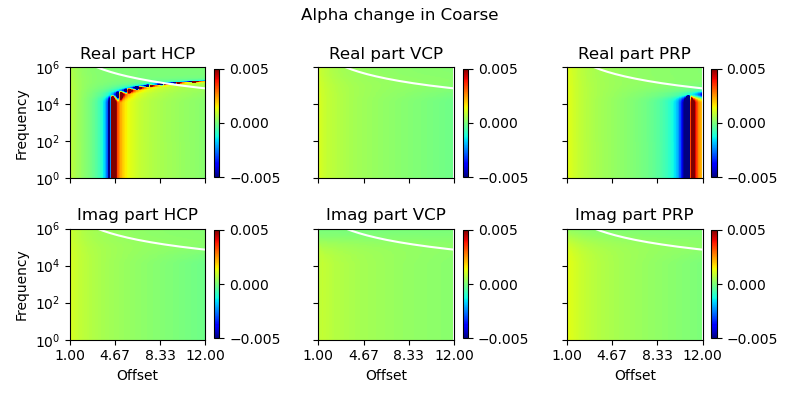

In [140]:
fig, ax = plt.subplots(2,3, figsize=(8,4), sharex=True, sharey=True)

vmin = -0.005
vmax = -vmin

c = ax[0,0].imshow(FreDev_coarse[0,0], cmap='jet', extent=[1, 12, 1, 1e6], aspect=1.5, vmin=vmin, vmax=vmax,)
ax[0,0].plot(coil_sp_in_1_coarse, Freq_l, 'w')
ax[0,0].set_title('Real part HCP')
fig.colorbar(c, ax=ax[0,0], shrink=0.8)

c = ax[1,0].imshow(FreDev_coarse[1,0], cmap='jet', extent=[1, 12, 1, 1e6], aspect=1.5, vmin=vmin, vmax=vmax,)
ax[1,0].plot(coil_sp_in_1_coarse, Freq_l, 'w')
ax[1,0].set_title('Imag part HCP')
fig.colorbar(c, ax=ax[1,0], shrink=0.8)

c = ax[0,1].imshow(FreDev_coarse[1,0], cmap='jet', extent=[1, 12, 1, 1e6], aspect=1.5, vmin=vmin, vmax=vmax,)
ax[0,1].plot(coil_sp_in_1_coarse, Freq_l, 'w')
ax[0,1].set_title('Real part VCP')
fig.colorbar(c, ax=ax[0,1], shrink=0.8)

c = ax[1,1].imshow(FreDev_coarse[1,1], cmap='jet', extent=[1, 12, 1, 1e6], aspect=1.5, vmin=vmin, vmax=vmax,)
ax[1,1].plot(coil_sp_in_1_coarse, Freq_l, 'w')
ax[1,1].set_title('Imag part VCP')
fig.colorbar(c, ax=ax[1,1], shrink=0.8)

c = ax[0,2].imshow(FreDev_coarse[2,0], cmap='jet', extent=[1, 12, 1, 1e6], aspect=1.5, vmin=vmin, vmax=vmax,)
ax[0,2].plot(coil_sp_in_1_coarse, Freq_l, 'w')
ax[0,2].set_title('Real part PRP')
fig.colorbar(c, ax=ax[0,2], shrink=0.8)

c = ax[1,2].imshow(FreDev_coarse[2,1], cmap='jet', extent=[1, 12, 1, 1e6], aspect=1.5, vmin=vmin, vmax=vmax,)
ax[1,2].plot(coil_sp_in_1_coarse, Freq_l, 'w')
ax[1,2].set_title('Imag part PRP')
fig.colorbar(c, ax=ax[1,2], shrink=0.8)

ax[0,0].set_yticks(Freq,)
ax[0,0].set_yscale('log')
ax[0,0].set_xticks(coil_spacing)
ax[0,0].set_ylim([np.min(Freq), np.max(Freq)])
ax[0,0].set_xlim([np.min(coil_spacing), np.max(coil_spacing)])
ax[1,0].set_xlabel('Offset')
ax[1,1].set_xlabel('Offset')
ax[1,2].set_xlabel('Offset')
ax[0,0].set_ylabel('Frequency')
ax[1,0].set_ylabel('Frequency')

fig.suptitle('Alpha change in Coarse')

plt.tight_layout()

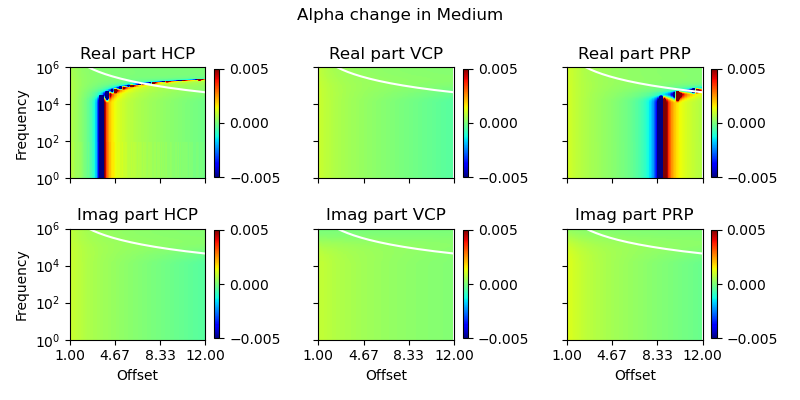

In [142]:
fig, ax = plt.subplots(2,3, figsize=(8,4), sharex=True, sharey=True)

vmin = -0.005
vmax = -vmin

c = ax[0,0].imshow(FreDev_medium[0,0], cmap='jet', extent=[1, 12, 1, 1e6], aspect=1.5, vmin=vmin, vmax=vmax,)
ax[0,0].plot(coil_sp_in_1_medium, Freq_l, 'w')
ax[0,0].set_title('Real part HCP')
fig.colorbar(c, ax=ax[0,0], shrink=0.8)

c = ax[1,0].imshow(FreDev_medium[1,0], cmap='jet', extent=[1, 12, 1, 1e6], aspect=1.5, vmin=vmin, vmax=vmax,)
ax[1,0].plot(coil_sp_in_1_medium, Freq_l, 'w')
ax[1,0].set_title('Imag part HCP')
fig.colorbar(c, ax=ax[1,0], shrink=0.8)

c = ax[0,1].imshow(FreDev_medium[1,0], cmap='jet', extent=[1, 12, 1, 1e6], aspect=1.5, vmin=vmin, vmax=vmax,)
ax[0,1].plot(coil_sp_in_1_medium, Freq_l, 'w')
ax[0,1].set_title('Real part VCP')
fig.colorbar(c, ax=ax[0,1], shrink=0.8)

c = ax[1,1].imshow(FreDev_medium[1,1], cmap='jet', extent=[1, 12, 1, 1e6], aspect=1.5, vmin=vmin, vmax=vmax,)
ax[1,1].plot(coil_sp_in_1_medium, Freq_l, 'w')
ax[1,1].set_title('Imag part VCP')
fig.colorbar(c, ax=ax[1,1], shrink=0.8)

c = ax[0,2].imshow(FreDev_medium[2,0], cmap='jet', extent=[1, 12, 1, 1e6], aspect=1.5, vmin=vmin, vmax=vmax,)
ax[0,2].plot(coil_sp_in_1_medium, Freq_l, 'w')
ax[0,2].set_title('Real part PRP')
fig.colorbar(c, ax=ax[0,2], shrink=0.8)

c = ax[1,2].imshow(FreDev_medium[2,1], cmap='jet', extent=[1, 12, 1, 1e6], aspect=1.5, vmin=vmin, vmax=vmax,)
ax[1,2].plot(coil_sp_in_1_medium, Freq_l, 'w')
ax[1,2].set_title('Imag part PRP')
fig.colorbar(c, ax=ax[1,2], shrink=0.8)

ax[0,0].set_yticks(Freq,)
ax[0,0].set_yscale('log')
ax[0,0].set_xticks(coil_spacing)
ax[0,0].set_ylim([np.min(Freq), np.max(Freq)])
ax[0,0].set_xlim([np.min(coil_spacing), np.max(coil_spacing)])
ax[1,0].set_xlabel('Offset')
ax[1,1].set_xlabel('Offset')
ax[1,2].set_xlabel('Offset')
ax[0,0].set_ylabel('Frequency')
ax[1,0].set_ylabel('Frequency')

fig.suptitle('Alpha change in Medium')

plt.tight_layout()

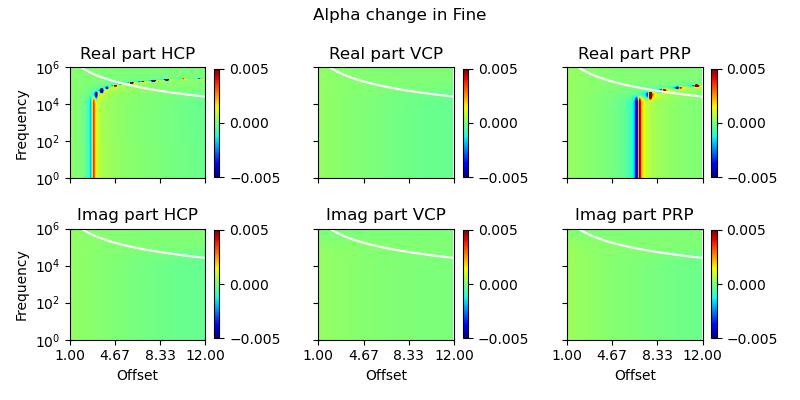

In [143]:
fig, ax = plt.subplots(2,3, figsize=(8,4), sharex=True, sharey=True)

vmin = -0.005
vmax = -vmin

c = ax[0,0].imshow(FreDev_fine[0,0], cmap='jet', extent=[1, 12, 1, 1e6], aspect=1.5, vmin=vmin, vmax=vmax,)
ax[0,0].plot(coil_sp_in_1_fine, Freq_l, 'w')
ax[0,0].set_title('Real part HCP')
fig.colorbar(c, ax=ax[0,0], shrink=0.8)

c = ax[1,0].imshow(FreDev_fine[1,0], cmap='jet', extent=[1, 12, 1, 1e6], aspect=1.5, vmin=vmin, vmax=vmax,)
ax[1,0].plot(coil_sp_in_1_fine, Freq_l, 'w')
ax[1,0].set_title('Imag part HCP')
fig.colorbar(c, ax=ax[1,0], shrink=0.8)

c = ax[0,1].imshow(FreDev_fine[1,0], cmap='jet', extent=[1, 12, 1, 1e6], aspect=1.5, vmin=vmin, vmax=vmax,)
ax[0,1].plot(coil_sp_in_1_fine, Freq_l, 'w')
ax[0,1].set_title('Real part VCP')
fig.colorbar(c, ax=ax[0,1], shrink=0.8)

c = ax[1,1].imshow(FreDev_fine[1,1], cmap='jet', extent=[1, 12, 1, 1e6], aspect=1.5, vmin=vmin, vmax=vmax,)
ax[1,1].plot(coil_sp_in_1_fine, Freq_l, 'w')
ax[1,1].set_title('Imag part VCP')
fig.colorbar(c, ax=ax[1,1], shrink=0.8)

c = ax[0,2].imshow(FreDev_fine[2,0], cmap='jet', extent=[1, 12, 1, 1e6], aspect=1.5, vmin=vmin, vmax=vmax,)
ax[0,2].plot(coil_sp_in_1_fine, Freq_l, 'w')
ax[0,2].set_title('Real part PRP')
fig.colorbar(c, ax=ax[0,2], shrink=0.8)

c = ax[1,2].imshow(FreDev_fine[2,1], cmap='jet', extent=[1, 12, 1, 1e6], aspect=1.5, vmin=vmin, vmax=vmax,)
ax[1,2].plot(coil_sp_in_1_fine, Freq_l, 'w')
ax[1,2].set_title('Imag part PRP')
fig.colorbar(c, ax=ax[1,2], shrink=0.8)

ax[0,0].set_yticks(Freq,)
ax[0,0].set_yscale('log')
ax[0,0].set_xticks(coil_spacing)
ax[0,0].set_ylim([np.min(Freq), np.max(Freq)])
ax[0,0].set_xlim([np.min(coil_spacing), np.max(coil_spacing)])
ax[1,0].set_xlabel('Offset')
ax[1,1].set_xlabel('Offset')
ax[1,2].set_xlabel('Offset')
ax[0,0].set_ylabel('Frequency')
ax[1,0].set_ylabel('Frequency')

fig.suptitle('Alpha change in Fine')

plt.tight_layout()

# Calculate frechet derivatives for n

In [149]:
delta = 0.1

data_coarse_1 = fop(alpha = Models['Coarse'][2],
                  n     = Models['Coarse'][3],
                  z_w   = 1,
                  theta_r = Models['Coarse'][0],
                  theta_s = Models['Coarse'][1],
                  a       = Models['Coarse'][4],
                  b       = Models['Coarse'][5],
                  sigma_w = Models['Coarse'][7],
                  sigma_s = Models['Coarse'][6],
                  z = z)

data_coarse_2 = fop(alpha = Models['Coarse'][2],
                  n     = Models['Coarse'][3]+delta,
                  z_w   = 1,
                  theta_r = Models['Coarse'][0],
                  theta_s = Models['Coarse'][1],
                  a       = Models['Coarse'][4],
                  b       = Models['Coarse'][5],
                  sigma_w = Models['Coarse'][7],
                  sigma_s = Models['Coarse'][6],
                  z = z)

FreDev_coarse = (data_coarse_1 - data_coarse_2)/data_coarse_1

data_medium_1 = fop(alpha = Models['Medium'][2],
                  n     = Models['Medium'][3],
                  z_w   = 1,
                  theta_r = Models['Medium'][0],
                  theta_s = Models['Medium'][1],
                  a       = Models['Medium'][4],
                  b       = Models['Medium'][5],
                  sigma_w = Models['Medium'][7],
                  sigma_s = Models['Medium'][6],
                  z = z)

data_medium_2 = fop(alpha = Models['Medium'][2],
                  n     = Models['Medium'][3]+delta,
                  z_w   = 1,
                  theta_r = Models['Medium'][0],
                  theta_s = Models['Medium'][1],
                  a       = Models['Medium'][4],
                  b       = Models['Medium'][5],
                  sigma_w = Models['Medium'][7],
                  sigma_s = Models['Medium'][6],
                  z = z)

FreDev_medium = (data_medium_1 - data_medium_2)/data_medium_1

data_fine_1 = fop(alpha = Models['Fine'][2],
                  n     = Models['Fine'][3],
                  z_w   = 1,
                  theta_r = Models['Fine'][0],
                  theta_s = Models['Fine'][1],
                  a       = Models['Fine'][4],
                  b       = Models['Fine'][5],
                  sigma_w = Models['Fine'][7],
                  sigma_s = Models['Fine'][6],
                  z = z)

data_fine_2 = fop(alpha = Models['Fine'][2],
                  n     = Models['Fine'][3]+delta,
                  z_w   = 1,
                  theta_r = Models['Fine'][0],
                  theta_s = Models['Fine'][1],
                  a       = Models['Fine'][4],
                  b       = Models['Fine'][5],
                  sigma_w = Models['Fine'][7],
                  sigma_s = Models['Fine'][6],
                  z = z)

FreDev_fine = (data_fine_1 - data_fine_2)/data_fine_1

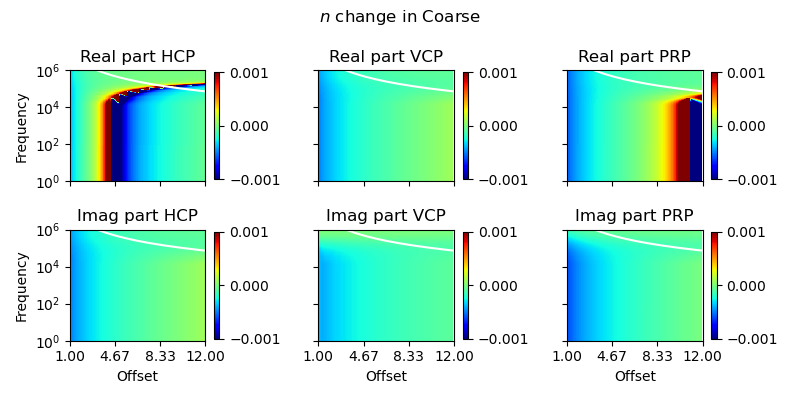

In [150]:
fig, ax = plt.subplots(2,3, figsize=(8,4), sharex=True, sharey=True)

vmin = -0.001
vmax = -vmin

c = ax[0,0].imshow(FreDev_coarse[0,0], cmap='jet', extent=[1, 12, 1, 1e6], aspect=1.5, vmin=vmin, vmax=vmax,)
ax[0,0].plot(coil_sp_in_1_coarse, Freq_l, 'w')
ax[0,0].set_title('Real part HCP')
fig.colorbar(c, ax=ax[0,0], shrink=0.8)

c = ax[1,0].imshow(FreDev_coarse[1,0], cmap='jet', extent=[1, 12, 1, 1e6], aspect=1.5, vmin=vmin, vmax=vmax,)
ax[1,0].plot(coil_sp_in_1_coarse, Freq_l, 'w')
ax[1,0].set_title('Imag part HCP')
fig.colorbar(c, ax=ax[1,0], shrink=0.8)

c = ax[0,1].imshow(FreDev_coarse[1,0], cmap='jet', extent=[1, 12, 1, 1e6], aspect=1.5, vmin=vmin, vmax=vmax,)
ax[0,1].plot(coil_sp_in_1_coarse, Freq_l, 'w')
ax[0,1].set_title('Real part VCP')
fig.colorbar(c, ax=ax[0,1], shrink=0.8)

c = ax[1,1].imshow(FreDev_coarse[1,1], cmap='jet', extent=[1, 12, 1, 1e6], aspect=1.5, vmin=vmin, vmax=vmax,)
ax[1,1].plot(coil_sp_in_1_coarse, Freq_l, 'w')
ax[1,1].set_title('Imag part VCP')
fig.colorbar(c, ax=ax[1,1], shrink=0.8)

c = ax[0,2].imshow(FreDev_coarse[2,0], cmap='jet', extent=[1, 12, 1, 1e6], aspect=1.5, vmin=vmin, vmax=vmax,)
ax[0,2].plot(coil_sp_in_1_coarse, Freq_l, 'w')
ax[0,2].set_title('Real part PRP')
fig.colorbar(c, ax=ax[0,2], shrink=0.8)

c = ax[1,2].imshow(FreDev_coarse[2,1], cmap='jet', extent=[1, 12, 1, 1e6], aspect=1.5, vmin=vmin, vmax=vmax,)
ax[1,2].plot(coil_sp_in_1_coarse, Freq_l, 'w')
ax[1,2].set_title('Imag part PRP')
fig.colorbar(c, ax=ax[1,2], shrink=0.8)

ax[0,0].set_yticks(Freq,)
ax[0,0].set_yscale('log')
ax[0,0].set_xticks(coil_spacing)
ax[0,0].set_ylim([np.min(Freq), np.max(Freq)])
ax[0,0].set_xlim([np.min(coil_spacing), np.max(coil_spacing)])
ax[1,0].set_xlabel('Offset')
ax[1,1].set_xlabel('Offset')
ax[1,2].set_xlabel('Offset')
ax[0,0].set_ylabel('Frequency')
ax[1,0].set_ylabel('Frequency')

fig.suptitle('$n$ change in Coarse')

plt.tight_layout()

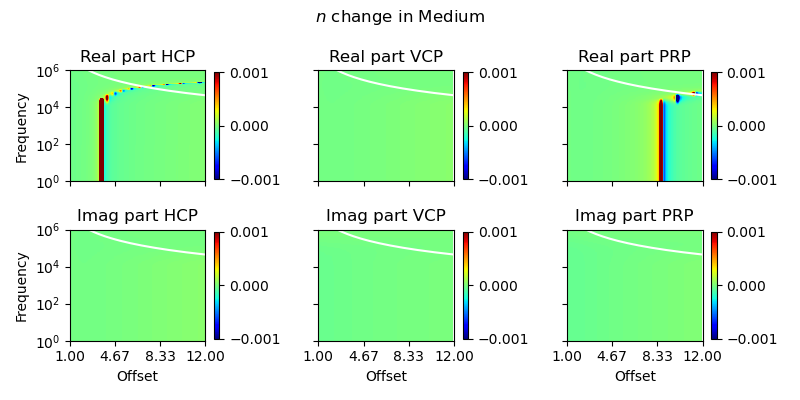

In [151]:
fig, ax = plt.subplots(2,3, figsize=(8,4), sharex=True, sharey=True)

vmin = -0.001
vmax = -vmin

c = ax[0,0].imshow(FreDev_medium[0,0], cmap='jet', extent=[1, 12, 1, 1e6], aspect=1.5, vmin=vmin, vmax=vmax,)
ax[0,0].plot(coil_sp_in_1_medium, Freq_l, 'w')
ax[0,0].set_title('Real part HCP')
fig.colorbar(c, ax=ax[0,0], shrink=0.8)

c = ax[1,0].imshow(FreDev_medium[1,0], cmap='jet', extent=[1, 12, 1, 1e6], aspect=1.5, vmin=vmin, vmax=vmax,)
ax[1,0].plot(coil_sp_in_1_medium, Freq_l, 'w')
ax[1,0].set_title('Imag part HCP')
fig.colorbar(c, ax=ax[1,0], shrink=0.8)

c = ax[0,1].imshow(FreDev_medium[1,0], cmap='jet', extent=[1, 12, 1, 1e6], aspect=1.5, vmin=vmin, vmax=vmax,)
ax[0,1].plot(coil_sp_in_1_medium, Freq_l, 'w')
ax[0,1].set_title('Real part VCP')
fig.colorbar(c, ax=ax[0,1], shrink=0.8)

c = ax[1,1].imshow(FreDev_medium[1,1], cmap='jet', extent=[1, 12, 1, 1e6], aspect=1.5, vmin=vmin, vmax=vmax,)
ax[1,1].plot(coil_sp_in_1_medium, Freq_l, 'w')
ax[1,1].set_title('Imag part VCP')
fig.colorbar(c, ax=ax[1,1], shrink=0.8)

c = ax[0,2].imshow(FreDev_medium[2,0], cmap='jet', extent=[1, 12, 1, 1e6], aspect=1.5, vmin=vmin, vmax=vmax,)
ax[0,2].plot(coil_sp_in_1_medium, Freq_l, 'w')
ax[0,2].set_title('Real part PRP')
fig.colorbar(c, ax=ax[0,2], shrink=0.8)

c = ax[1,2].imshow(FreDev_medium[2,1], cmap='jet', extent=[1, 12, 1, 1e6], aspect=1.5, vmin=vmin, vmax=vmax,)
ax[1,2].plot(coil_sp_in_1_medium, Freq_l, 'w')
ax[1,2].set_title('Imag part PRP')
fig.colorbar(c, ax=ax[1,2], shrink=0.8)

ax[0,0].set_yticks(Freq,)
ax[0,0].set_yscale('log')
ax[0,0].set_xticks(coil_spacing)
ax[0,0].set_ylim([np.min(Freq), np.max(Freq)])
ax[0,0].set_xlim([np.min(coil_spacing), np.max(coil_spacing)])
ax[1,0].set_xlabel('Offset')
ax[1,1].set_xlabel('Offset')
ax[1,2].set_xlabel('Offset')
ax[0,0].set_ylabel('Frequency')
ax[1,0].set_ylabel('Frequency')

fig.suptitle('$n$ change in Medium')

plt.tight_layout()

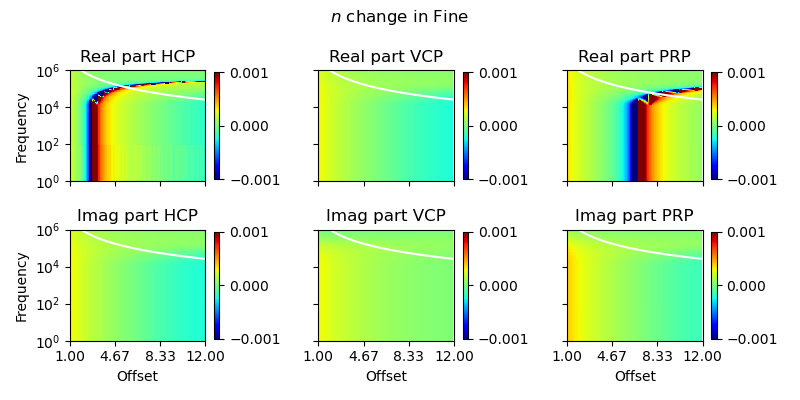

In [152]:
fig, ax = plt.subplots(2,3, figsize=(8,4), sharex=True, sharey=True)

vmin = -0.001
vmax = -vmin

c = ax[0,0].imshow(FreDev_fine[0,0], cmap='jet', extent=[1, 12, 1, 1e6], aspect=1.5, vmin=vmin, vmax=vmax,)
ax[0,0].plot(coil_sp_in_1_fine, Freq_l, 'w')
ax[0,0].set_title('Real part HCP')
fig.colorbar(c, ax=ax[0,0], shrink=0.8)

c = ax[1,0].imshow(FreDev_fine[1,0], cmap='jet', extent=[1, 12, 1, 1e6], aspect=1.5, vmin=vmin, vmax=vmax,)
ax[1,0].plot(coil_sp_in_1_fine, Freq_l, 'w')
ax[1,0].set_title('Imag part HCP')
fig.colorbar(c, ax=ax[1,0], shrink=0.8)

c = ax[0,1].imshow(FreDev_fine[1,0], cmap='jet', extent=[1, 12, 1, 1e6], aspect=1.5, vmin=vmin, vmax=vmax,)
ax[0,1].plot(coil_sp_in_1_fine, Freq_l, 'w')
ax[0,1].set_title('Real part VCP')
fig.colorbar(c, ax=ax[0,1], shrink=0.8)

c = ax[1,1].imshow(FreDev_fine[1,1], cmap='jet', extent=[1, 12, 1, 1e6], aspect=1.5, vmin=vmin, vmax=vmax,)
ax[1,1].plot(coil_sp_in_1_fine, Freq_l, 'w')
ax[1,1].set_title('Imag part VCP')
fig.colorbar(c, ax=ax[1,1], shrink=0.8)

c = ax[0,2].imshow(FreDev_fine[2,0], cmap='jet', extent=[1, 12, 1, 1e6], aspect=1.5, vmin=vmin, vmax=vmax,)
ax[0,2].plot(coil_sp_in_1_fine, Freq_l, 'w')
ax[0,2].set_title('Real part PRP')
fig.colorbar(c, ax=ax[0,2], shrink=0.8)

c = ax[1,2].imshow(FreDev_fine[2,1], cmap='jet', extent=[1, 12, 1, 1e6], aspect=1.5, vmin=vmin, vmax=vmax,)
ax[1,2].plot(coil_sp_in_1_fine, Freq_l, 'w')
ax[1,2].set_title('Imag part PRP')
fig.colorbar(c, ax=ax[1,2], shrink=0.8)

ax[0,0].set_yticks(Freq,)
ax[0,0].set_yscale('log')
ax[0,0].set_xticks(coil_spacing)
ax[0,0].set_ylim([np.min(Freq), np.max(Freq)])
ax[0,0].set_xlim([np.min(coil_spacing), np.max(coil_spacing)])
ax[1,0].set_xlabel('Offset')
ax[1,1].set_xlabel('Offset')
ax[1,2].set_xlabel('Offset')
ax[0,0].set_ylabel('Frequency')
ax[1,0].set_ylabel('Frequency')

fig.suptitle('$n$ change in Fine')

plt.tight_layout()

# Calculate frechet derivatives for $z_w$

In [153]:
delta = 0.1

data_coarse_1 = fop(alpha = Models['Coarse'][2],
                  n     = Models['Coarse'][3],
                  z_w   = 1,
                  theta_r = Models['Coarse'][0],
                  theta_s = Models['Coarse'][1],
                  a       = Models['Coarse'][4],
                  b       = Models['Coarse'][5],
                  sigma_w = Models['Coarse'][7],
                  sigma_s = Models['Coarse'][6],
                  z = z)

data_coarse_2 = fop(alpha = Models['Coarse'][2],
                  n     = Models['Coarse'][3],
                  z_w   = 1,
                  theta_r = Models['Coarse'][0]+delta,
                  theta_s = Models['Coarse'][1],
                  a       = Models['Coarse'][4],
                  b       = Models['Coarse'][5],
                  sigma_w = Models['Coarse'][7],
                  sigma_s = Models['Coarse'][6],
                  z = z)

FreDev_coarse = (data_coarse_1 - data_coarse_2)/data_coarse_1

data_medium_1 = fop(alpha = Models['Medium'][2],
                  n     = Models['Medium'][3],
                  z_w   = 1,
                  theta_r = Models['Medium'][0],
                  theta_s = Models['Medium'][1],
                  a       = Models['Medium'][4],
                  b       = Models['Medium'][5],
                  sigma_w = Models['Medium'][7],
                  sigma_s = Models['Medium'][6],
                  z = z)

data_medium_2 = fop(alpha = Models['Medium'][2],
                  n     = Models['Medium'][3],
                  z_w   = 1,
                  theta_r = Models['Medium'][0]+delta,
                  theta_s = Models['Medium'][1],
                  a       = Models['Medium'][4],
                  b       = Models['Medium'][5],
                  sigma_w = Models['Medium'][7],
                  sigma_s = Models['Medium'][6],
                  z = z)

FreDev_medium = (data_medium_1 - data_medium_2)/data_medium_1

data_fine_1 = fop(alpha = Models['Fine'][2],
                  n     = Models['Fine'][3],
                  z_w   = 1,
                  theta_r = Models['Fine'][0],
                  theta_s = Models['Fine'][1],
                  a       = Models['Fine'][4],
                  b       = Models['Fine'][5],
                  sigma_w = Models['Fine'][7],
                  sigma_s = Models['Fine'][6],
                  z = z)

data_fine_2 = fop(alpha = Models['Fine'][2],
                  n     = Models['Fine'][3],
                  z_w   = 1,
                  theta_r = Models['Fine'][0]+delta,
                  theta_s = Models['Fine'][1],
                  a       = Models['Fine'][4],
                  b       = Models['Fine'][5],
                  sigma_w = Models['Fine'][7],
                  sigma_s = Models['Fine'][6],
                  z = z)

FreDev_fine = (data_fine_1 - data_fine_2)/data_fine_1

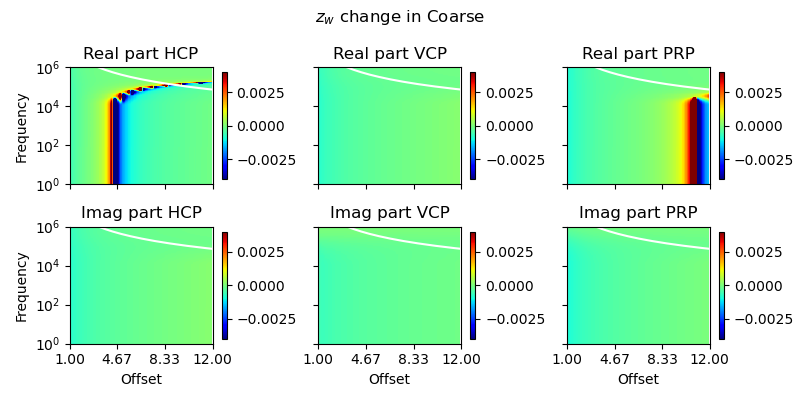

In [156]:
fig, ax = plt.subplots(2,3, figsize=(8,4), sharex=True, sharey=True)

vmin = -0.004
vmax = -vmin

c = ax[0,0].imshow(FreDev_coarse[0,0], cmap='jet', extent=[1, 12, 1, 1e6], aspect=1.5, vmin=vmin, vmax=vmax,)
ax[0,0].plot(coil_sp_in_1_coarse, Freq_l, 'w')
ax[0,0].set_title('Real part HCP')
fig.colorbar(c, ax=ax[0,0], shrink=0.8)

c = ax[1,0].imshow(FreDev_coarse[1,0], cmap='jet', extent=[1, 12, 1, 1e6], aspect=1.5, vmin=vmin, vmax=vmax,)
ax[1,0].plot(coil_sp_in_1_coarse, Freq_l, 'w')
ax[1,0].set_title('Imag part HCP')
fig.colorbar(c, ax=ax[1,0], shrink=0.8)

c = ax[0,1].imshow(FreDev_coarse[1,0], cmap='jet', extent=[1, 12, 1, 1e6], aspect=1.5, vmin=vmin, vmax=vmax,)
ax[0,1].plot(coil_sp_in_1_coarse, Freq_l, 'w')
ax[0,1].set_title('Real part VCP')
fig.colorbar(c, ax=ax[0,1], shrink=0.8)

c = ax[1,1].imshow(FreDev_coarse[1,1], cmap='jet', extent=[1, 12, 1, 1e6], aspect=1.5, vmin=vmin, vmax=vmax,)
ax[1,1].plot(coil_sp_in_1_coarse, Freq_l, 'w')
ax[1,1].set_title('Imag part VCP')
fig.colorbar(c, ax=ax[1,1], shrink=0.8)

c = ax[0,2].imshow(FreDev_coarse[2,0], cmap='jet', extent=[1, 12, 1, 1e6], aspect=1.5, vmin=vmin, vmax=vmax,)
ax[0,2].plot(coil_sp_in_1_coarse, Freq_l, 'w')
ax[0,2].set_title('Real part PRP')
fig.colorbar(c, ax=ax[0,2], shrink=0.8)

c = ax[1,2].imshow(FreDev_coarse[2,1], cmap='jet', extent=[1, 12, 1, 1e6], aspect=1.5, vmin=vmin, vmax=vmax,)
ax[1,2].plot(coil_sp_in_1_coarse, Freq_l, 'w')
ax[1,2].set_title('Imag part PRP')
fig.colorbar(c, ax=ax[1,2], shrink=0.8)

ax[0,0].set_yticks(Freq,)
ax[0,0].set_yscale('log')
ax[0,0].set_xticks(coil_spacing)
ax[0,0].set_ylim([np.min(Freq), np.max(Freq)])
ax[0,0].set_xlim([np.min(coil_spacing), np.max(coil_spacing)])
ax[1,0].set_xlabel('Offset')
ax[1,1].set_xlabel('Offset')
ax[1,2].set_xlabel('Offset')
ax[0,0].set_ylabel('Frequency')
ax[1,0].set_ylabel('Frequency')

fig.suptitle('$z_w$ change in Coarse')

plt.tight_layout()

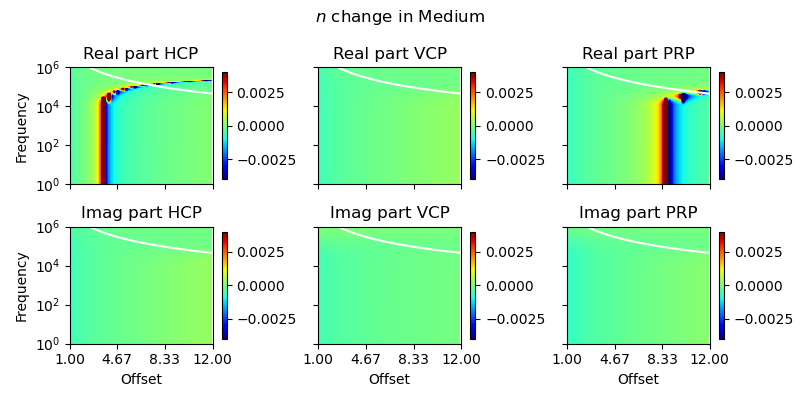

In [157]:
fig, ax = plt.subplots(2,3, figsize=(8,4), sharex=True, sharey=True)

vmin = -0.004
vmax = -vmin

c = ax[0,0].imshow(FreDev_medium[0,0], cmap='jet', extent=[1, 12, 1, 1e6], aspect=1.5, vmin=vmin, vmax=vmax,)
ax[0,0].plot(coil_sp_in_1_medium, Freq_l, 'w')
ax[0,0].set_title('Real part HCP')
fig.colorbar(c, ax=ax[0,0], shrink=0.8)

c = ax[1,0].imshow(FreDev_medium[1,0], cmap='jet', extent=[1, 12, 1, 1e6], aspect=1.5, vmin=vmin, vmax=vmax,)
ax[1,0].plot(coil_sp_in_1_medium, Freq_l, 'w')
ax[1,0].set_title('Imag part HCP')
fig.colorbar(c, ax=ax[1,0], shrink=0.8)

c = ax[0,1].imshow(FreDev_medium[1,0], cmap='jet', extent=[1, 12, 1, 1e6], aspect=1.5, vmin=vmin, vmax=vmax,)
ax[0,1].plot(coil_sp_in_1_medium, Freq_l, 'w')
ax[0,1].set_title('Real part VCP')
fig.colorbar(c, ax=ax[0,1], shrink=0.8)

c = ax[1,1].imshow(FreDev_medium[1,1], cmap='jet', extent=[1, 12, 1, 1e6], aspect=1.5, vmin=vmin, vmax=vmax,)
ax[1,1].plot(coil_sp_in_1_medium, Freq_l, 'w')
ax[1,1].set_title('Imag part VCP')
fig.colorbar(c, ax=ax[1,1], shrink=0.8)

c = ax[0,2].imshow(FreDev_medium[2,0], cmap='jet', extent=[1, 12, 1, 1e6], aspect=1.5, vmin=vmin, vmax=vmax,)
ax[0,2].plot(coil_sp_in_1_medium, Freq_l, 'w')
ax[0,2].set_title('Real part PRP')
fig.colorbar(c, ax=ax[0,2], shrink=0.8)

c = ax[1,2].imshow(FreDev_medium[2,1], cmap='jet', extent=[1, 12, 1, 1e6], aspect=1.5, vmin=vmin, vmax=vmax,)
ax[1,2].plot(coil_sp_in_1_medium, Freq_l, 'w')
ax[1,2].set_title('Imag part PRP')
fig.colorbar(c, ax=ax[1,2], shrink=0.8)

ax[0,0].set_yticks(Freq,)
ax[0,0].set_yscale('log')
ax[0,0].set_xticks(coil_spacing)
ax[0,0].set_ylim([np.min(Freq), np.max(Freq)])
ax[0,0].set_xlim([np.min(coil_spacing), np.max(coil_spacing)])
ax[1,0].set_xlabel('Offset')
ax[1,1].set_xlabel('Offset')
ax[1,2].set_xlabel('Offset')
ax[0,0].set_ylabel('Frequency')
ax[1,0].set_ylabel('Frequency')

fig.suptitle('$n$ change in Medium')

plt.tight_layout()

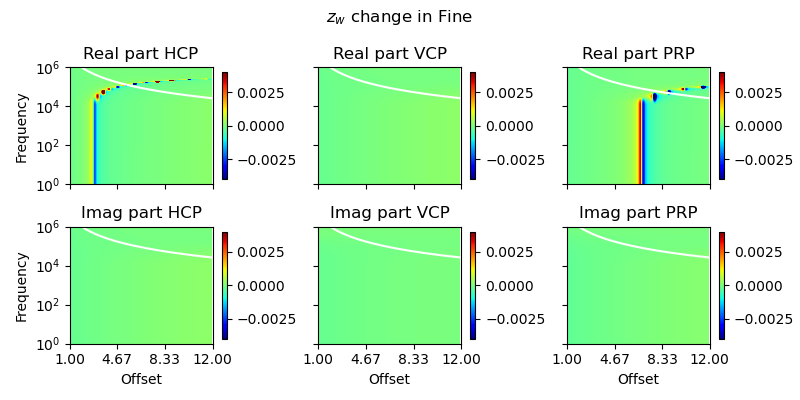

In [162]:
fig, ax = plt.subplots(2,3, figsize=(8,4), sharex=True, sharey=True)

vmin = -0.004
vmax = -vmin

c = ax[0,0].imshow(FreDev_fine[0,0], cmap='jet', extent=[1, 12, 1, 1e6], aspect=1.5, vmin=vmin, vmax=vmax,)
ax[0,0].plot(coil_sp_in_1_fine, Freq_l, 'w')
ax[0,0].set_title('Real part HCP')
fig.colorbar(c, ax=ax[0,0], shrink=0.8)

c = ax[1,0].imshow(FreDev_fine[1,0], cmap='jet', extent=[1, 12, 1, 1e6], aspect=1.5, vmin=vmin, vmax=vmax,)
ax[1,0].plot(coil_sp_in_1_fine, Freq_l, 'w')
ax[1,0].set_title('Imag part HCP')
fig.colorbar(c, ax=ax[1,0], shrink=0.8)

c = ax[0,1].imshow(FreDev_fine[1,0], cmap='jet', extent=[1, 12, 1, 1e6], aspect=1.5, vmin=vmin, vmax=vmax,)
ax[0,1].plot(coil_sp_in_1_fine, Freq_l, 'w')
ax[0,1].set_title('Real part VCP')
fig.colorbar(c, ax=ax[0,1], shrink=0.8)

c = ax[1,1].imshow(FreDev_fine[1,1], cmap='jet', extent=[1, 12, 1, 1e6], aspect=1.5, vmin=vmin, vmax=vmax,)
ax[1,1].plot(coil_sp_in_1_fine, Freq_l, 'w')
ax[1,1].set_title('Imag part VCP')
fig.colorbar(c, ax=ax[1,1], shrink=0.8)

c = ax[0,2].imshow(FreDev_fine[2,0], cmap='jet', extent=[1, 12, 1, 1e6], aspect=1.5, vmin=vmin, vmax=vmax,)
ax[0,2].plot(coil_sp_in_1_fine, Freq_l, 'w')
ax[0,2].set_title('Real part PRP')
fig.colorbar(c, ax=ax[0,2], shrink=0.8)

c = ax[1,2].imshow(FreDev_fine[2,1], cmap='jet', extent=[1, 12, 1, 1e6], aspect=1.5, vmin=vmin, vmax=vmax,)
ax[1,2].plot(coil_sp_in_1_fine, Freq_l, 'w')
ax[1,2].set_title('Imag part PRP')
fig.colorbar(c, ax=ax[1,2], shrink=0.8)

ax[0,0].set_yticks(Freq,)
ax[0,0].set_yscale('log')
ax[0,0].set_xticks(coil_spacing)
ax[0,0].set_ylim([np.min(Freq), np.max(Freq)])
ax[0,0].set_xlim([np.min(coil_spacing), np.max(coil_spacing)])
ax[1,0].set_xlabel('Offset')
ax[1,1].set_xlabel('Offset')
ax[1,2].set_xlabel('Offset')
ax[0,0].set_ylabel('Frequency')
ax[1,0].set_ylabel('Frequency')

fig.suptitle('$z_w$ change in Fine')

plt.tight_layout()